In [46]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd



In [47]:
pip install rioxarray

Note: you may need to restart the kernel to use updated packages.


In [48]:
import rioxarray as rxr

In [49]:
from rasterio.plot import plotting_extent

In [50]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [51]:
import geopandas as gpd

In [52]:
pip install rasterstats

Note: you may need to restart the kernel to use updated packages.


In [53]:
pip install earthpy

Note: you may need to restart the kernel to use updated packages.


In [54]:
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

In [55]:
sns.set_style("white")
sns.set(font_scale=1.5)

data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME,"earth-analytics", "data"))

In [56]:
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar", "california", "neon-sjer-site", "2013", "lidar", "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

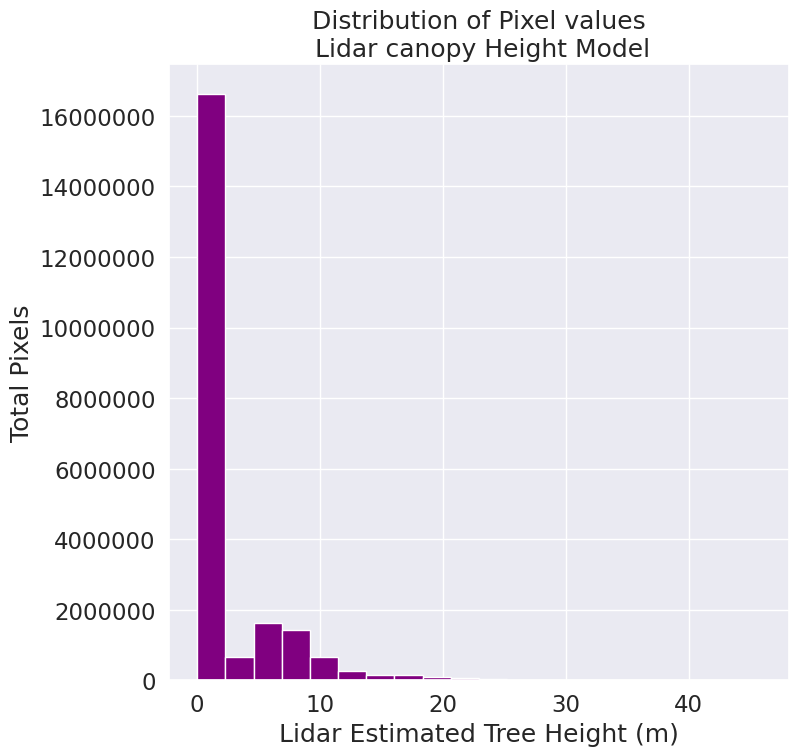

In [57]:
ax = ep.hist(sjer_chm_data.values, figsize=(8,8), colors="purple", xlabel ="Lidar Estimated Tree Height (m)", ylabel="Total Pixels", 
             title=" Distribution of Pixel values \n Lidar canopy Height Model")

ax[1].ticklabel_format(useOffset=False, style="plain")

In [58]:
print("Mean:", sjer_chm_data.mean().values)
print("Max:", sjer_chm_data.max().values)
print("Min", sjer_chm_data.min().values)

Mean: 1.9355862
Max: 45.879997
Min 0.0


In [59]:
sjer_chm_data_no_zeros = sjer_chm_data.where(sjer_chm_data != 0, np.nan)

print("Mean:", sjer_chm_data_no_zeros.mean().values)
print("Max:", sjer_chm_data_no_zeros.max().values)
print("Min", sjer_chm_data_no_zeros.min().values)

Mean: 8.213505
Max: 45.879997
Min 2.0


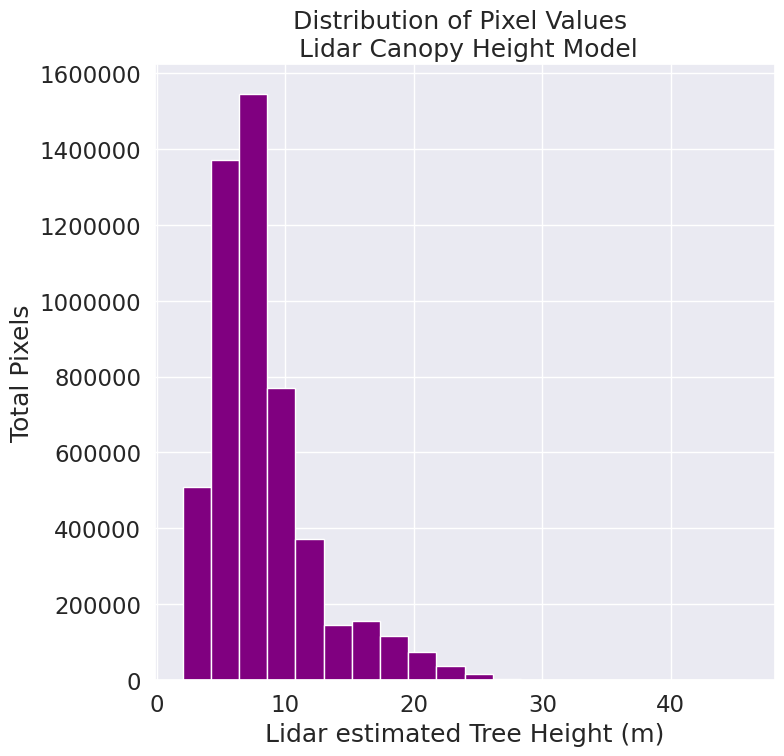

In [60]:
ax= ep.hist(sjer_chm_data_no_zeros.values, figsize=(8,8), colors="purple", xlabel="Lidar estimated Tree Height (m)", ylabel="Total Pixels",
            title="Distribution of Pixel Values \n Lidar Canopy Height Model")

ax[1].ticklabel_format(useOffset=False, style="plain")

In [61]:
sjer_centroids_path = os.path.join("spatial-vector-lidar", "california", "neon-sjer-site", "vector_data", "SJER_plot_centroids.shp")

sjer_plots_points = gpd.read_file(sjer_centroids_path)

type(sjer_plots_points)

geopandas.geodataframe.GeoDataFrame

In [62]:
sjer_plots_points.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

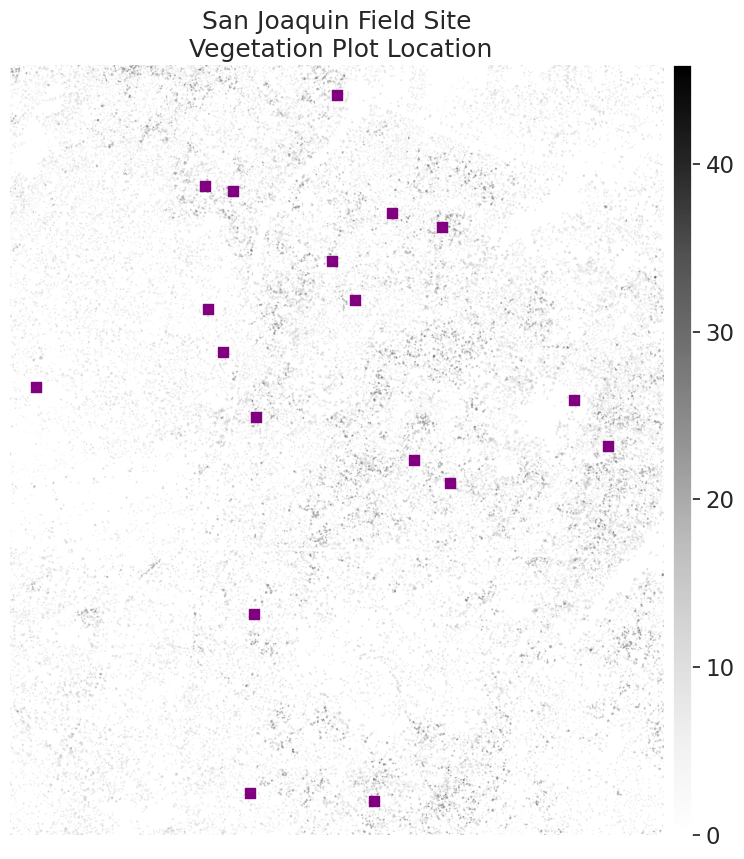

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(sjer_chm_data, extent=plotting_extent(sjer_chm_data, sjer_chm_data.rio.transform()), cmap="Greys", 
              title=" San Joaquin Field Site \n Vegetation Plot Location", scale=False, ax=ax)

sjer_plots_points.plot(ax=ax, marker="s", markersize=45, color="purple")

ax.set_axis_off()
plt.show()

In [66]:
sjer_plots_poly = sjer_plots_points.copy()

sjer_plots_poly["geometry"] = sjer_plots_points.geometry.buffer(20)
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


In [67]:
output_path = os.path.join("spatial-vector-lidar", "outputs")

if not os.path.isdir(output_path):os.mkdir(output_path)

plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")

sjer_plots_poly.to_file(plot_buffer_path)

In [68]:
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,sjer_chm_data_no_zeros.values,nodata=-999,affine=sjer_chm_data_no_zeros.rio.transform(),
    geojson_out=True,copy_properties=True,stats="count min mean max median")

type(sjer_tree_heights)

list

In [69]:
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,min,max,mean,count,median
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,2.04,19.049999,11.544347,161,12.62
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,2.10,24.019999,10.369277,443,7.87
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,2.82,16.070000,7.518398,643,6.80
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,3.24,11.059999,7.675346,245,7.93
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,3.38,5.740000,4.591177,17,4.45


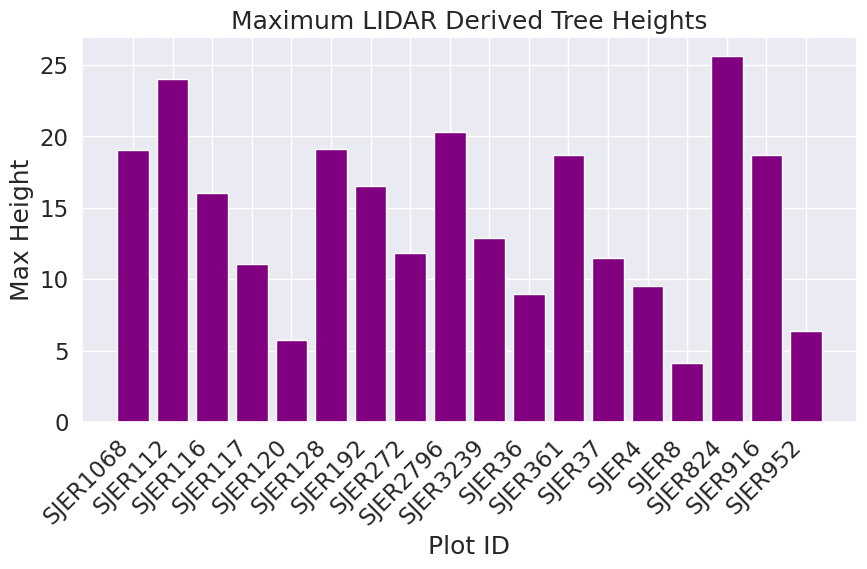

In [70]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(sjer_lidar_height_df['Plot_ID'],sjer_lidar_height_df['max'],color="purple")

ax.set(xlabel='Plot ID', ylabel='Max Height',title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [71]:
sjer_tree_heights_ras = rs.zonal_stats(plot_buffer_path,sjer_chm_data_no_zeros.values,nodata=-999,affine=sjer_chm_data_no_zeros.rio.transform(),
    geojson_out=True,raster_out=True,copy_properties=True,stats="count min mean max median")

sjer_lidar_height_df_ras = gpd.GeoDataFrame.from_features(sjer_tree_heights_ras)

sjer_lidar_height_df_ras[["Plot_ID", "count",  "geometry", "mini_raster_affine",  "mini_raster_array"]].head()

,Plot_ID,count,geometry,mini_raster_affine,mini_raster_array
0,SJER1068,161,"POLYGON ((255872.376 4111567.818, 255872.280 4...","(1.0, 0.0, 255832.0, 0.0, -1.0, 4111588.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,SJER112,443,"POLYGON ((257426.967 4111298.971, 257426.871 4...","(1.0, 0.0, 257386.0, 0.0, -1.0, 4111319.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,SJER116,643,"POLYGON ((256858.760 4110819.876, 256858.664 4...","(1.0, 0.0, 256818.0, 0.0, -1.0, 4110840.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,SJER117,245,"POLYGON ((256196.947 4108752.026, 256196.851 4...","(1.0, 0.0, 256156.0, 0.0, -1.0, 4108773.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,SJER120,17,"POLYGON ((255988.372 4110476.079, 255988.276 4...","(1.0, 0.0, 255948.0, 0.0, -1.0, 4110497.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."


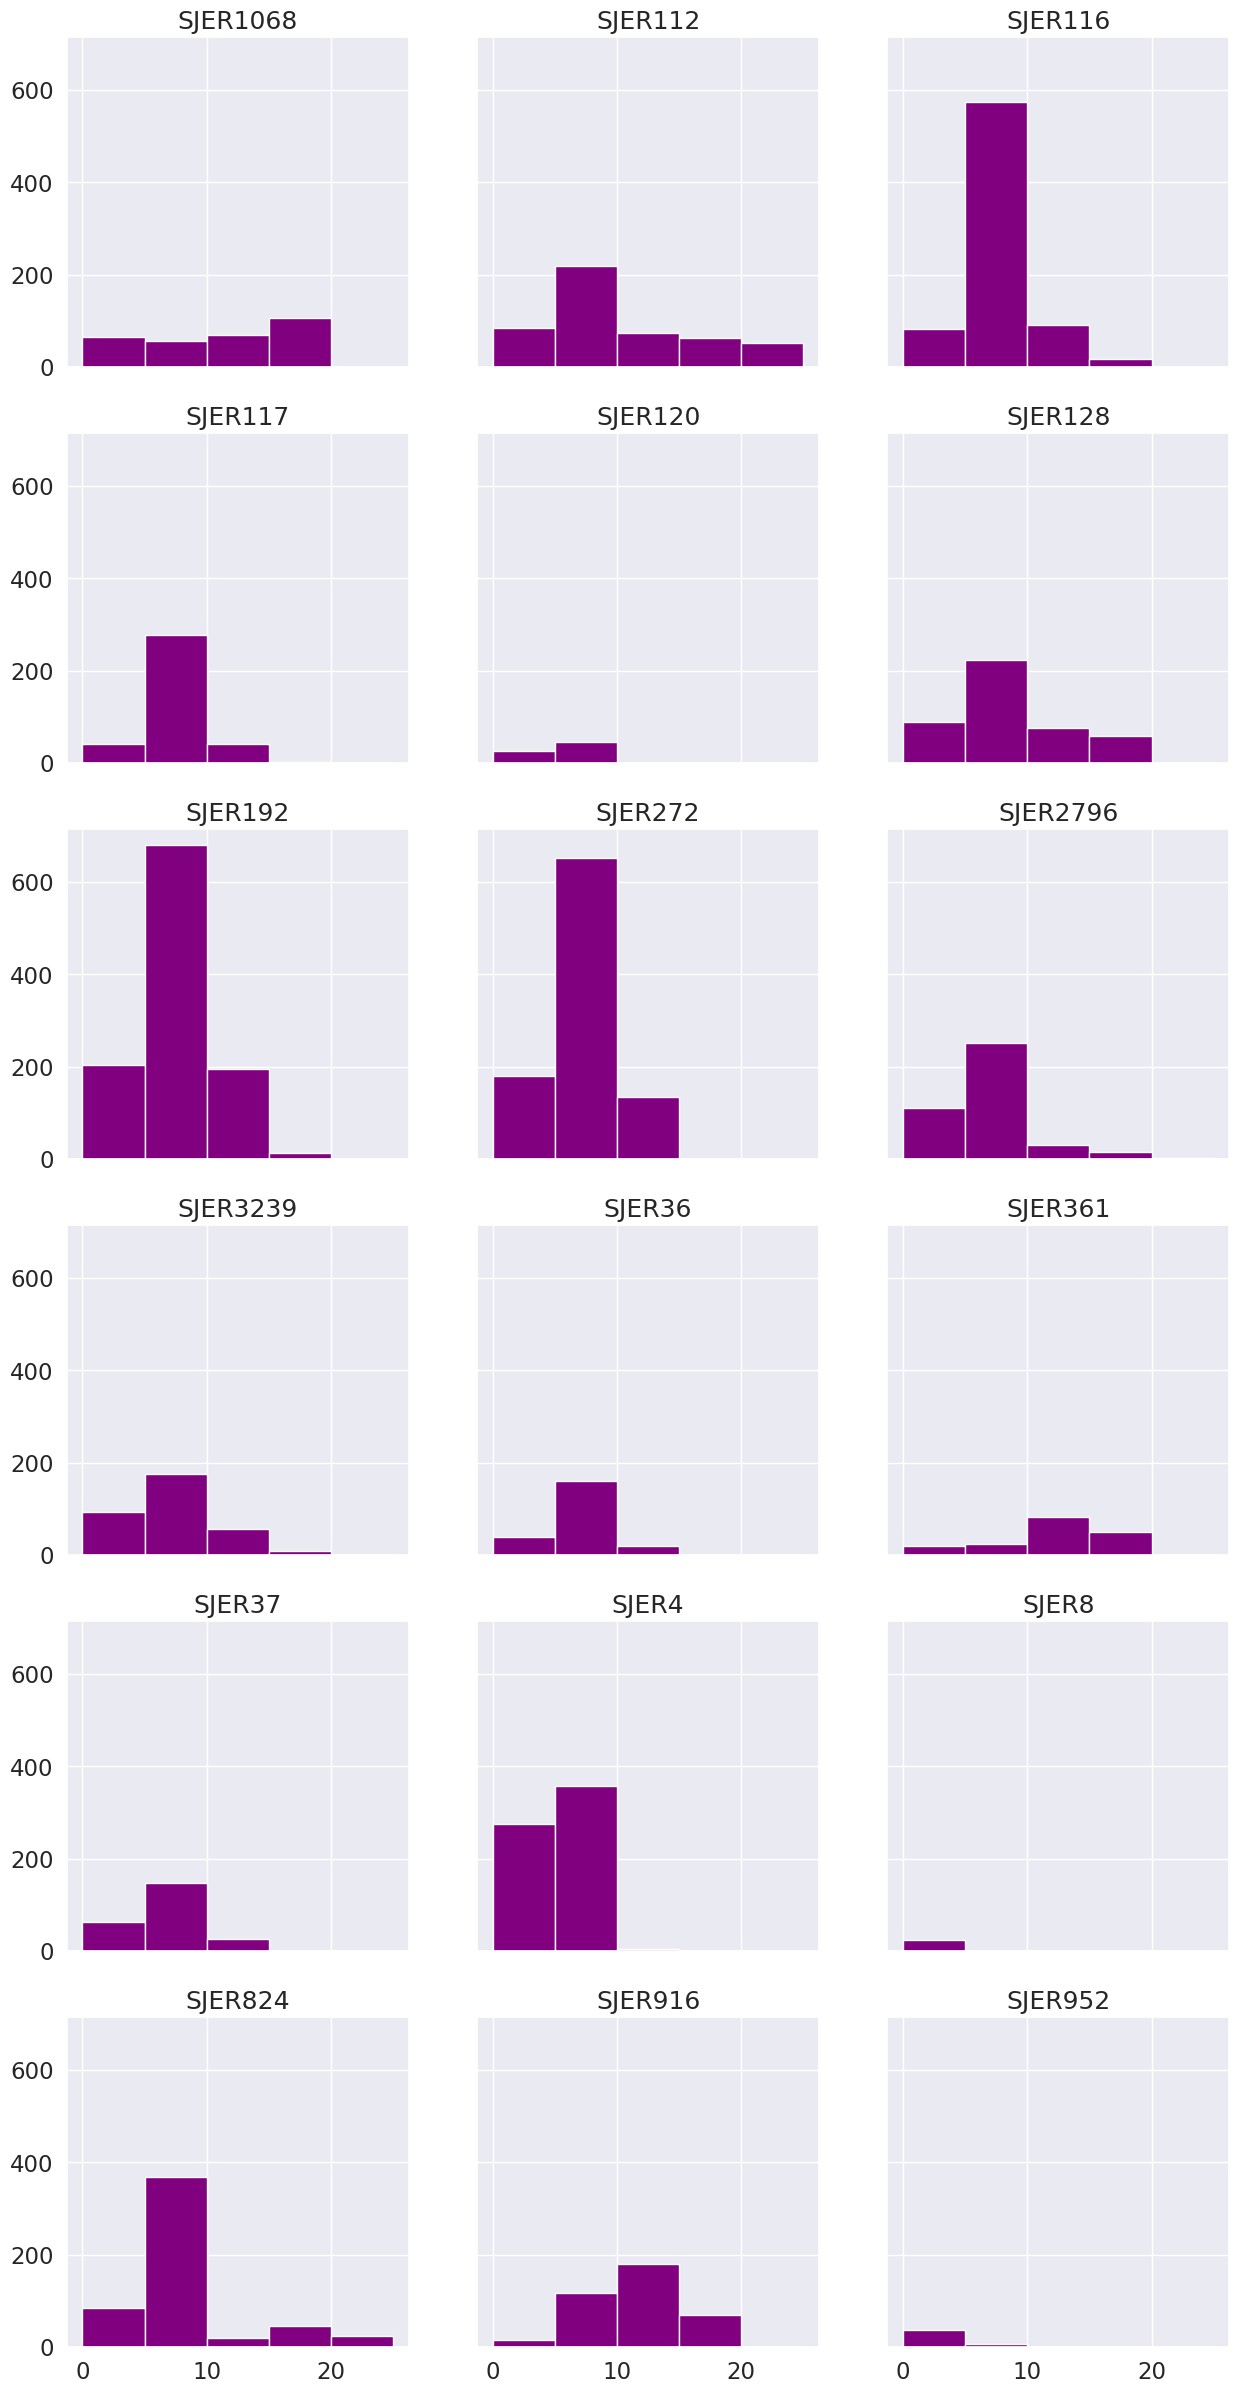

In [72]:
site_names = list(sjer_lidar_height_df_ras["Plot_ID"])

arr = np.stack(sjer_lidar_height_df_ras['mini_raster_array'])

ep.hist(arr,bins=[0, 5, 10, 15, 20, 25],cols=3,title=site_names, figsize=(15, 30))

plt.show()